In [ ]:
# ===================================================================
# CELL 1: Mount Google Drive dan Setup Kaggle
# ===================================================================
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Setup Kaggle credentials
kaggle_json_path = '/content/drive/MyDrive/Kaggle/kaggle.json'

# Buat folder .kaggle di root
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy kaggle.json ke folder yang tepat
!cp "{kaggle_json_path}" /root/.kaggle/kaggle.json

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

print("✓ Google Drive mounted")
print("✓ Kaggle credentials configured")


Mounted at /content/drive
✓ Google Drive mounted
✓ Kaggle credentials configured


In [ ]:
# ===================================================================
# CELL 2: Install Required Libraries
# ===================================================================
!pip install -q kaggle opencv-python-headless pillow numpy matplotlib scikit-image pandas

print("✓ All libraries installed successfully")



✓ All libraries installed successfully


In [ ]:
# ===================================================================
# CELL 3.2: Download Datasets dengan Struktur Folder Terorganisir
# ===================================================================
import os
from pathlib import Path
import shutil
from tqdm import tqdm

# Base path di Google Drive
BASE_DRIVE_PATH = '/content/drive/MyDrive/BurnDetection_ProcessedDataset'

# Path utama untuk semua dataset
ALL_DATASETS_DIR = f'{BASE_DRIVE_PATH}/ALL'
os.makedirs(ALL_DATASETS_DIR, exist_ok=True)

# Path untuk masing-masing dataset (dalam folder ALL)
DATASET1_DIR = f'{ALL_DATASETS_DIR}/DATASET_1_SkinBurn'
DATASET2_DIR = f'{ALL_DATASETS_DIR}/DATASET_2_HumanSkinBurns'

# Buat folder utama untuk masing-masing dataset
os.makedirs(DATASET1_DIR, exist_ok=True)
os.makedirs(DATASET2_DIR, exist_ok=True)

print(f"📁 Membuat struktur folder terorganisir...")
print(f"├── {ALL_DATASETS_DIR}")
print(f"│   ├── DATASET_1_SkinBurn/")
print(f"│   └── DATASET_2_HumanSkinBurns/")
print("=" * 70)

# =============================================
# FUNGSI UNTUK COPY DENGAN STRUKTUR FOLDER
# =============================================
def copy_with_structure(source_dir, target_base_dir, dataset_name):
    """
    Copy semua gambar dari source ke target dengan struktur folder asli
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff',
                       '.JPG', '.JPEG', '.PNG', '.BMP', '.TIFF']

    stats = {
        'total_images': 0,
        'subfolders': {},
        'files_copied': []
    }

    print(f"\n📂 Memproses {dataset_name}...")

    for root, dirs, files in os.walk(source_dir):
        # Relatif path dari source directory
        rel_path = os.path.relpath(root, source_dir)

        # Target directory (jaga struktur asli)
        if rel_path == '.':
            target_dir = target_base_dir
        else:
            target_dir = os.path.join(target_base_dir, rel_path)
            os.makedirs(target_dir, exist_ok=True)

        # Filter dan copy file gambar
        image_files = [f for f in files if Path(f).suffix.lower() in image_extensions]

        if image_files:
            if rel_path != '.':
                stats['subfolders'][rel_path] = len(image_files)

            for file in tqdm(image_files, desc=f"  {rel_path if rel_path != '.' else 'root'}", leave=False):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(target_dir, file)

                # Jika file sudah ada, tambahkan angka unik
                counter = 1
                original_dst = dst_path
                while os.path.exists(dst_path):
                    name, ext = os.path.splitext(file)
                    dst_path = os.path.join(target_dir, f"{name}_{counter}{ext}")
                    counter += 1

                shutil.copy2(src_path, dst_path)
                stats['total_images'] += 1
                stats['files_copied'].append(dst_path)

    return stats

# =============================================
# DOWNLOAD DAN ORGANISASI DATASET 1
# =============================================
print("\n📥 DOWNLOADING DATASET 1: Skin Burn Dataset...")
print("-" * 50)

# Download dataset 1
dataset1_temp = '/tmp/dataset1_temp'
os.makedirs(dataset1_temp, exist_ok=True)
!kaggle datasets download -d shubhambaid/skin-burn-dataset -p {dataset1_temp} --unzip

# Copy dengan struktur folder
print(f"\n🔄 Mengorganisir Dataset 1 ke dalam folder...")
dataset1_stats = copy_with_structure(dataset1_temp, DATASET1_DIR, "Dataset 1 - Skin Burn")

# =============================================
# DOWNLOAD DAN ORGANISASI DATASET 2
# =============================================
print("\n\n📥 DOWNLOADING DATASET 2: Human Skin Burns...")
print("-" * 50)

# Download dataset 2
dataset2_temp = '/tmp/dataset2_temp'
os.makedirs(dataset2_temp, exist_ok=True)
!kaggle datasets download -d brendarangelolvera/human-skin-burns -p {dataset2_temp} --unzip

# Copy dengan struktur folder
print(f"\n🔄 Mengorganisir Dataset 2 ke dalam folder...")
dataset2_stats = copy_with_structure(dataset2_temp, DATASET2_DIR, "Dataset 2 - Human Skin Burns")

# =============================================
# TAMPILKAN STRUKTUR FOLDER YANG DIBUAT
# =============================================
def print_folder_structure(base_path, indent=""):
    """Print struktur folder dengan indentation yang rapi"""
    items = os.listdir(base_path)

    for i, item in enumerate(sorted(items)):
        item_path = os.path.join(base_path, item)

        # Skip jika file (bukan folder)
        if os.path.isfile(item_path):
            continue

        is_last = (i == len(items) - 1)

        if is_last:
            print(f"{indent}└── 📁 {item}/")
            next_indent = indent + "    "
        else:
            print(f"{indent}├── 📁 {item}/")
            next_indent = indent + "│   "

        # Hitung jumlah file gambar di folder ini
        image_count = 0
        for root, dirs, files in os.walk(item_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    image_count += 1

        if image_count > 0:
            print(f"{next_indent}    └── 📸 {image_count} gambar")

        # Rekursif untuk subfolder
        print_folder_structure(item_path, next_indent)

print(f"\n{'='*70}")
print("📁 STRUKTUR FOLDER YANG DIBUAT")
print(f"{'='*70}")
print(f"{ALL_DATASETS_DIR}/")
print_folder_structure(ALL_DATASETS_DIR)

# =============================================
# STATISTIK DETAIL PER DATASET
# =============================================
def print_detailed_stats(stats, dataset_name, dataset_path):
    """Print statistik detail untuk dataset"""
    print(f"\n{'='*70}")
    print(f"📊 STATISTIK {dataset_name}")
    print(f"{'='*70}")
    print(f"📍 Lokasi: {dataset_path}")
    print(f"📈 Total gambar: {stats['total_images']}")

    if stats['subfolders']:
        print(f"\n📂 Subfolder dan distribusi gambar:")
        for folder, count in stats['subfolders'].items():
            if folder != '.':
                percentage = (count / stats['total_images']) * 100
                print(f"  ├── 📁 {folder}/: {count} gambar ({percentage:.1f}%)")

    # Contoh file
    print(f"\n📸 Contoh file:")
    for i, file_path in enumerate(stats['files_copied'][:5], 1):
        file_name = os.path.basename(file_path)
        rel_path = os.path.relpath(os.path.dirname(file_path), dataset_path)
        if rel_path == '.':
            print(f"  {i}. {file_name}")
        else:
            print(f"  {i}. {rel_path}/{file_name}")

print_detailed_stats(dataset1_stats, "DATASET 1 - SKIN BURN DATASET", DATASET1_DIR)
print_detailed_stats(dataset2_stats, "DATASET 2 - HUMAN SKIN BURNS", DATASET2_DIR)

# Clean up temporary files
shutil.rmtree(dataset1_temp, ignore_errors=True)
shutil.rmtree(dataset2_temp, ignore_errors=True)

📁 Membuat struktur folder terorganisir...
├── /content/drive/MyDrive/BurnDetection_ProcessedDataset/ALL
│   ├── DATASET_1_SkinBurn/
│   └── DATASET_2_HumanSkinBurns/

📥 DOWNLOADING DATASET 1: Skin Burn Dataset...
--------------------------------------------------
Dataset URL: https://www.kaggle.com/datasets/shubhambaid/skin-burn-dataset
License(s): CC0-1.0
  0% 0.00/16.6M [00:00<?, ?B/s]
100% 16.6M/16.6M [00:00<00:00, 1.47GB/s]

🔄 Mengorganisir Dataset 1 ke dalam folder...

📂 Memproses Dataset 1 - Skin Burn...




📥 DOWNLOADING DATASET 2: Human Skin Burns...
--------------------------------------------------
Dataset URL: https://www.kaggle.com/datasets/brendarangelolvera/human-skin-burns
License(s): unknown
 92% 727M/791M [00:10<00:01, 36.7MB/s]
100% 791M/791M [00:10<00:00, 76.9MB/s]

🔄 Mengorganisir Dataset 2 ke dalam folder...

📂 Memproses Dataset 2 - Human Skin Burns...



📁 STRUKTUR FOLDER YANG DIBUAT
/content/drive/MyDrive/BurnDetection_ProcessedDataset/ALL/
├── 📁 DATASET_1_SkinBurn/
│       └── 📸 1227 gambar
└── 📁 DATASET_2_HumanSkinBurns/
        └── 📸 2838 gambar
    ├── 📁 background/
    │       └── 📸 724 gambar
    │   └── 📁 background/
    │           └── 📸 724 gambar
    ├── 📁 burns/
    │       └── 📸 496 gambar
    ├── 📁 burns1-100/
    │       └── 📸 100 gambar
    │   └── 📁 burns1-100/
    │           └── 📸 100 gambar
    ├── 📁 burns1001-1100/
    │       └── 📸 88 gambar
    │   └── 📁 burns1001-1100/
    │           └── 📸 88 gambar
    ├── 📁 burns101-200/
    │       └── 📸 100 gambar
    │   └── 📁 burns101-200/
    │           └── 📸 100 gambar
    ├── 📁 burns201-300/
    │       └── 📸 100 gambar
    │   └── 📁 burns201-300/
    │           └── 📸 100 gambar
    ├── 📁 burns301-400/
    │       └── 📸 100 gambar
    │   └── 📁 burns301-400/
    │           └── 📸 100 gambar
    ├── 📁 burns401-500/
    │       └── 📸 100 gambar
    │   └── 📁 burns401-

In [ ]:
# ===================================================================
# CELL 4: Import Libraries dan Setup untuk Dataset Terpilih
# ===================================================================
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from pathlib import Path
import shutil
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import random
import hashlib

# Untuk reproducibility
np.random.seed(42)
random.seed(42)

# =============================================
# SETUP PATHS UNTUK DATASET TERPILIH
# =============================================
print("=" * 70)
print("SETUP UNTUK 200 GAMBAR TERPILIH")
print("=" * 70)

# Path dataset terpilih dari Google Drive
SELECTED_DIR = '/content/drive/MyDrive/BurnDetection_ProcessedDataset/SELECTED_200'

# Cek apakah folder SELECTED_200 ada dan berisi gambar
if not os.path.exists(SELECTED_DIR):
    print(f"❌ ERROR: Folder {SELECTED_DIR} tidak ditemukan!")
    print("   Pastikan Anda sudah memilih 200 gambar secara manual")
    print("   dan menyimpannya di folder tersebut.")
    raise FileNotFoundError(f"Folder {SELECTED_DIR} tidak ditemukan")

# =============================================
# FUNGSI UNTUK DETEKSI DAN FILTER DUPLIKAT
# =============================================
def get_file_hash(filepath):
    """Generate hash untuk file (untuk deteksi duplikat)"""
    hash_md5 = hashlib.md5()
    with open(filepath, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def find_unique_images(folder_path):
    """
    Cari gambar unik (tidak duplikat) di folder
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff',
                       '.JPG', '.JPEG', '.PNG', '.BMP', '.TIFF']

    all_files = []
    for ext in image_extensions:
        all_files.extend(list(Path(folder_path).glob(f'*{ext}')))
        all_files.extend(list(Path(folder_path).glob(f'*{ext.upper()}')))

    print(f"📁 Scanning folder: {folder_path}")
    print(f"   Found {len(all_files)} files with image extensions")

    # Deteksi dan hapus duplikat berdasarkan hash
    unique_files = []
    file_hashes = set()
    duplicate_count = 0

    print("\n🔍 Checking for duplicate files...")
    for img_path in tqdm(all_files, desc="Checking duplicates"):
        try:
            file_hash = get_file_hash(str(img_path))
            if file_hash not in file_hashes:
                file_hashes.add(file_hash)
                unique_files.append(img_path)
            else:
                duplicate_count += 1
                print(f"   ⚠️  Duplicate found: {img_path.name}")
        except Exception as e:
            print(f"   ❌ Error reading {img_path.name}: {e}")

    if duplicate_count > 0:
        print(f"\n⚠️  Found {duplicate_count} duplicate files")
        print(f"✅ Keeping {len(unique_files)} unique files")

    return unique_files

def clean_and_count_images(folder_path):
    """
    Bersihkan dan hitung gambar yang valid
    """
    print(f"\n🧹 Cleaning and validating images in {folder_path}")

    valid_images = []
    invalid_images = []

    # Cari semua file dengan ekstensi gambar
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    all_files = []
    for ext in image_extensions:
        all_files.extend(list(Path(folder_path).glob(f'*{ext}')))
        all_files.extend(list(Path(folder_path).glob(f'*{ext.upper()}')))

    print(f"   Total files found: {len(all_files)}")

    # Validasi setiap file
    for img_path in tqdm(all_files, desc="Validating images"):
        try:
            # Coba baca gambar
            img = cv2.imread(str(img_path))
            if img is not None:
                # Cek ukuran minimal
                h, w = img.shape[:2]
                if h > 10 and w > 10:  # Minimal 10x10 pixel
                    valid_images.append(img_path)
                else:
                    invalid_images.append((img_path.name, "Too small"))
            else:
                invalid_images.append((img_path.name, "Cannot read"))
        except Exception as e:
            invalid_images.append((img_path.name, str(e)))

    # Report
    print(f"\n📊 Validation Results:")
    print(f"   ✅ Valid images: {len(valid_images)}")
    print(f"   ❌ Invalid images: {len(invalid_images)}")

    if invalid_images:
        print(f"\n⚠️  Invalid images (first 5):")
        for i, (name, reason) in enumerate(invalid_images[:5]):
            print(f"   {i+1}. {name}: {reason}")

    return valid_images, invalid_images

# =============================================
# SCAN DAN VALIDASI GAMBAR
# =============================================
print("\n🔍 SCANNING AND VALIDATING IMAGES...")
print("-" * 50)

# Cari gambar unik
unique_files = find_unique_images(SELECTED_DIR)

# Validasi gambar
valid_images, invalid_images = clean_and_count_images(SELECTED_DIR)

# Filter hanya file yang valid dan unik
# Pertama, dapatkan set dari path valid_images
valid_paths = set([str(p) for p in valid_images])
# Kemudian filter unique_files yang ada di valid_paths
selected_files = [p for p in unique_files if str(p) in valid_paths]

print(f"\n{'='*50}")
print(f"📊 FINAL COUNT:")
print(f"{'='*50}")
print(f"📁 Folder: {SELECTED_DIR}")
print(f"📄 Files with image extensions: {len(unique_files)}")
print(f"✅ Valid & unique images: {len(selected_files)}")
print(f"❌ Invalid/duplicate: {len(invalid_images)}")
print(f"{'='*50}")

if len(selected_files) != 200:
    print(f"\n⚠️  WARNING: Found {len(selected_files)} images (expected 200)")
    print("   Please check your SELECTED_200 folder.")
    response = input(f"\n❓ Continue with {len(selected_files)} images? (y/n): ")
    if response.lower() != 'y':
        print("❌ Process cancelled by user")
        raise SystemExit("Process cancelled")
else:
    print(f"\n✅ Perfect! Found exactly 200 images")

# =============================================
# SETUP FOLDER PROCESSING DI COLAB
# =============================================
# Base directory di Colab untuk processing
BASE_DIR = '/content/selected_200_dataset'
OUTPUT_DIR = '/content/processed_dataset'
ORGANIZED_DIR = f'{OUTPUT_DIR}/organized'        # Untuk gambar yang sudah diorganisir
COIN_DIR = f'{OUTPUT_DIR}/with_coins'            # Gambar dengan koin
PREPROCESSED_DIR = f'{OUTPUT_DIR}/preprocessed'  # Setelah resize + normalisasi
AUGMENTED_DIR = f'{OUTPUT_DIR}/augmented'        # Setelah augmentasi
METADATA_DIR = f'{OUTPUT_DIR}/metadata'          # Metadata dan dokumentasi

# Buat semua folder
for dir_path in [BASE_DIR, OUTPUT_DIR, ORGANIZED_DIR, COIN_DIR,
                 PREPROCESSED_DIR, AUGMENTED_DIR, METADATA_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Copy semua gambar terpilih ke BASE_DIR di Colab untuk processing
print(f"\n📋 Copying {len(selected_files)} images to Colab...")
for img_path in tqdm(selected_files, desc="Copying"):
    dst_path = os.path.join(BASE_DIR, img_path.name)

    # Jika file sudah ada, tambahkan prefix
    counter = 1
    original_dst = dst_path
    while os.path.exists(dst_path):
        name, ext = os.path.splitext(img_path.name)
        dst_path = os.path.join(BASE_DIR, f"{name}_{counter}{ext}")
        counter += 1

    shutil.copy2(str(img_path), dst_path)

print("\n" + "=" * 70)
print("✅ SETUP COMPLETE")
print("=" * 70)
print(f"✓ Libraries imported")
print(f"✓ Directories created")
print(f"✓ {len(selected_files)} valid images copied to Colab")
print(f"\n📂 Output structure:")
print(f"  BASE_DIR: {BASE_DIR}")
print(f"  └── {len(os.listdir(BASE_DIR))} images")
print(f"\n  OUTPUT_DIR: {OUTPUT_DIR}")
print(f"    ├── organized/")
print(f"    ├── with_coins/")
print(f"    ├── preprocessed/")
print(f"    ├── augmented/")
print(f"    └── metadata/")
print("=" * 70)

# =============================================
# VERIFIKASI FILE DI BASE_DIR
# =============================================
print("\n🔍 VERIFYING COPIED FILES...")
base_files = list(Path(BASE_DIR).glob('*'))
image_files = [f for f in base_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']]

print(f"📁 Files in BASE_DIR: {len(base_files)}")
print(f"📸 Image files: {len(image_files)}")

if len(image_files) > 0:
    print("\n📋 First 10 files:")
    for i, f in enumerate(image_files[:10]):
        size_kb = os.path.getsize(f) / 1024
        print(f"  {i+1:2d}. {f.name} ({size_kb:.1f} KB)")

    # Cek duplikat di BASE_DIR juga
    base_hashes = set()
    base_duplicates = 0
    for img_path in image_files:
        try:
            file_hash = get_file_hash(str(img_path))
            if file_hash in base_hashes:
                base_duplicates += 1
            else:
                base_hashes.add(file_hash)
        except:
            pass

    if base_duplicates > 0:
        print(f"\n⚠️  Found {base_duplicates} duplicates in BASE_DIR (should be 0)")
    else:
        print(f"\n✅ No duplicates in BASE_DIR")
else:
    print("\n❌ No image files found in BASE_DIR!")

print("=" * 70)

SETUP UNTUK 200 GAMBAR TERPILIH

🔍 SCANNING AND VALIDATING IMAGES...
--------------------------------------------------
📁 Scanning folder: /content/drive/MyDrive/BurnDetection_ProcessedDataset/SELECTED_200
   Found 200 files with image extensions

🔍 Checking for duplicate files...


Checking duplicates:  24%|██▍       | 49/200 [00:03<00:03, 41.99it/s]

   ⚠️  Duplicate found: img437.jpg
   ⚠️  Duplicate found: img1402.jpg
   ⚠️  Duplicate found: img451.jpg


Checking duplicates:  48%|████▊     | 96/200 [00:04<00:01, 52.72it/s]

   ⚠️  Duplicate found: img1394.jpg
   ⚠️  Duplicate found: img217.jpg


Checking duplicates:  66%|██████▋   | 133/200 [00:04<00:00, 88.66it/s]

   ⚠️  Duplicate found: img626.jpg
   ⚠️  Duplicate found: img917.jpg
   ⚠️  Duplicate found: img705.jpg


Checking duplicates:  84%|████████▎ | 167/200 [00:15<00:05,  5.70it/s]

   ⚠️  Duplicate found: burn_0929.jpg


Checking duplicates:  86%|████████▋ | 173/200 [00:16<00:04,  5.86it/s]

   ⚠️  Duplicate found: img1200.jpg
   ⚠️  Duplicate found: img1381.jpg
   ⚠️  Duplicate found: img1211.jpg


Checking duplicates:  95%|█████████▌| 190/200 [00:17<00:01,  8.07it/s]

   ⚠️  Duplicate found: img1217.jpg
   ⚠️  Duplicate found: img1212.jpg


Checking duplicates: 100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


   ⚠️  Duplicate found: img538.jpg

⚠️  Found 15 duplicate files
✅ Keeping 185 unique files

🧹 Cleaning and validating images in /content/drive/MyDrive/BurnDetection_ProcessedDataset/SELECTED_200
   Total files found: 200


Validating images: 100%|██████████| 200/200 [00:01<00:00, 122.45it/s]



📊 Validation Results:
   ✅ Valid images: 200
   ❌ Invalid images: 0

📊 FINAL COUNT:
📁 Folder: /content/drive/MyDrive/BurnDetection_ProcessedDataset/SELECTED_200
📄 Files with image extensions: 185
✅ Valid & unique images: 185
❌ Invalid/duplicate: 0

⚠️  WARNING: Found 185 images (expected 200)
   Please check your SELECTED_200 folder.

❓ Continue with 185 images? (y/n): y

📋 Copying 185 images to Colab...


Copying: 100%|██████████| 185/185 [00:00<00:00, 337.08it/s]


✅ SETUP COMPLETE
✓ Libraries imported
✓ Directories created
✓ 185 valid images copied to Colab

📂 Output structure:
  BASE_DIR: /content/selected_200_dataset
  └── 185 images

  OUTPUT_DIR: /content/processed_dataset
    ├── organized/
    ├── with_coins/
    ├── preprocessed/
    ├── augmented/
    └── metadata/

🔍 VERIFYING COPIED FILES...
📁 Files in BASE_DIR: 185
📸 Image files: 185

📋 First 10 files:
   1. burn_0995.jpg (479.5 KB)
   2. img1375.jpg (71.6 KB)
   3. img526.jpg (4.7 KB)
   4. img1189.jpg (5.9 KB)
   5. img191.jpg (3.5 KB)
   6. img1323.jpg (6.0 KB)
   7. img1283.jpg (55.7 KB)
   8. img660.jpg (4.0 KB)
   9. burn_0828.jpg (218.8 KB)
  10. burn_0554.jpg (263.5 KB)

✅ No duplicates in BASE_DIR


In [ ]:
# ===================================================================
# CELL 5: Eksplorasi Dataset Terpilih
# ===================================================================
def explore_dataset_structure(base_path):
    """
    Eksplorasi struktur folder dataset dan hitung jumlah gambar
    """
    print("=" * 70)
    print("EXPLORASI DATASET TERPILIH (200 GAMBAR)")
    print("=" * 70)

    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    dataset_info = {}
    total_size = 0

    for root, dirs, files in os.walk(base_path):
        # Filter hanya file gambar
        image_files = [f for f in files if Path(f).suffix.lower() in image_extensions]

        if image_files:
            rel_path = os.path.relpath(root, base_path)

            # Hitung total size
            folder_size = 0
            for file in image_files:
                file_path = os.path.join(root, file)
                folder_size += os.path.getsize(file_path)

            total_size += folder_size

            dataset_info[rel_path] = {
                'count': len(image_files),
                'size_mb': folder_size / (1024 * 1024),
                'files': image_files[:5]  # Sample 5 files
            }

            print(f"\n📁 {rel_path}")
            print(f"   Images: {len(image_files)}")
            print(f"   Size: {folder_size / (1024 * 1024):.2f} MB")
            print(f"   Sample: {', '.join(image_files[:3])}")

    return dataset_info, total_size

# Eksplorasi dataset
dataset_structure, total_size_mb = explore_dataset_structure(BASE_DIR)

# Hitung total gambar
total_images = sum([info['count'] for info in dataset_structure.values()])
print(f"\n{'=' * 70}")
print(f"📊 TOTAL: {total_images} images ({total_size_mb:.2f} MB)")
print(f"🎯 Target: 200 images (✓ {total_images}/200)")
print(f"{'=' * 70}")


EXPLORASI DATASET TERPILIH (200 GAMBAR)

📁 .
   Images: 185
   Size: 14.92 MB
   Sample: burn_0995.jpg, img1375.jpg, img526.jpg

📊 TOTAL: 185 images (15646633.00 MB)
🎯 Target: 200 images (✓ 185/200)


In [ ]:
# ===================================================================
# CELL 6: Organisasi dan Penamaan Sistematis
# ===================================================================
def organize_selected_images(base_path, output_path):
    """
    Organisir gambar dengan penamaan sistematis: burn_0001.jpg, burn_0002.jpg, dst.
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    collected_images = []
    counter = 1

    print("🔄 Organizing images with systematic naming...")

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if Path(file).suffix.lower() in image_extensions:
                src_path = os.path.join(root, file)

                # Buat nama file baru yang sistematis
                ext = Path(file).suffix.lower()
                # Konversi semua ke .jpg untuk konsistensi
                new_filename = f"burn_{counter:04d}.jpg"
                dst_path = os.path.join(output_path, new_filename)

                # Baca dan simpan sebagai JPEG (konsistensi format)
                img = cv2.imread(src_path)
                if img is not None:
                    cv2.imwrite(dst_path, img, [cv2.IMWRITE_JPEG_QUALITY, 95])

                    collected_images.append({
                        'id': counter,
                        'original_path': src_path,
                        'new_path': dst_path,
                        'original_filename': file,
                        'new_filename': new_filename,
                        'original_size': os.path.getsize(src_path),
                        'new_size': os.path.getsize(dst_path)
                    })

                    counter += 1
                else:
                    print(f"⚠️  Failed to read: {file}")

    print(f"✓ Organized {len(collected_images)} images")
    print(f"  Format: burn_0001.jpg to burn_{counter-1:04d}.jpg")

    return collected_images

# Organisasi gambar
print("\n" + "=" * 70)
print("ORGANIZING IMAGES WITH SYSTEMATIC NAMING")
print("=" * 70)

collected_data = organize_selected_images(BASE_DIR, ORGANIZED_DIR)

# Simpan metadata collection
collection_df = pd.DataFrame(collected_data)
collection_df.to_csv(f'{METADATA_DIR}/collection_metadata.csv', index=False)
print(f"✓ Metadata saved to: {METADATA_DIR}/collection_metadata.csv")

# Display sample
print(f"\n📊 Sample of organized data:")
print(collection_df[['id', 'original_filename', 'new_filename', 'original_size', 'new_size']].head())



ORGANIZING IMAGES WITH SYSTEMATIC NAMING
🔄 Organizing images with systematic naming...
✓ Organized 185 images
  Format: burn_0001.jpg to burn_0185.jpg
✓ Metadata saved to: /content/processed_dataset/metadata/collection_metadata.csv

📊 Sample of organized data:
   id original_filename   new_filename  original_size  new_size
0   1     burn_0995.jpg  burn_0001.jpg         491044    195695
1   2       img1375.jpg  burn_0002.jpg          73314    116848
2   3        img526.jpg  burn_0003.jpg           4767     11935
3   4       img1189.jpg  burn_0004.jpg           5998     14766
4   5        img191.jpg  burn_0005.jpg           3564      8220


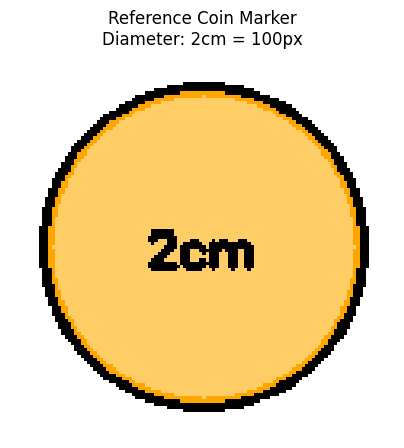

✓ Coin marker created: 2cm = 100 pixels


In [ ]:
# ===================================================================
# CELL 7: Fungsi Membuat Koin Referensi (SAMA)
# ===================================================================
def create_coin_marker(diameter_cm=2, pixels_per_cm=50, coin_color='gold'):
    """
    Membuat gambar koin referensi virtual
    """
    # Hitung diameter dalam pixel
    diameter_px = int(diameter_cm * pixels_per_cm)

    # Buat canvas RGBA (dengan alpha untuk transparansi)
    size = diameter_px + 20  # Tambah padding
    coin_img = np.zeros((size, size, 4), dtype=np.uint8)

    # Koordinat pusat
    center = (size // 2, size // 2)
    radius = diameter_px // 2

    # Pilih warna berdasarkan jenis koin
    if coin_color == 'gold':
        outer_color = (0, 165, 255, 255)  # Orange/gold BGR
        inner_color = (102, 205, 255, 255)  # Light orange
    elif coin_color == 'silver':
        outer_color = (192, 192, 192, 255)  # Silver
        inner_color = (220, 220, 220, 255)  # Light silver
    else:  # bronze
        outer_color = (19, 69, 139, 255)  # Bronze
        inner_color = (50, 100, 180, 255)  # Light bronze

    # Gambar lingkaran luar (border)
    cv2.circle(coin_img, center, radius, outer_color, -1)

    # Gambar lingkaran dalam (lebih terang)
    cv2.circle(coin_img, center, radius - 3, inner_color, -1)

    # Gambar border hitam tipis
    cv2.circle(coin_img, center, radius, (0, 0, 0, 255), 2)

    # Tambahkan text "2cm" di tengah
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"{diameter_cm}cm"
    text_size = cv2.getTextSize(text, font, 0.5, 2)[0]
    text_x = center[0] - text_size[0] // 2
    text_y = center[1] + text_size[1] // 2
    cv2.putText(coin_img, text, (text_x, text_y), font, 0.5, (0, 0, 0, 255), 2)

    return coin_img, diameter_px

# Test membuat koin
test_coin, diameter = create_coin_marker(diameter_cm=2, pixels_per_cm=50)
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(test_coin, cv2.COLOR_BGRA2RGBA))
plt.title(f"Reference Coin Marker\nDiameter: 2cm = {diameter}px")
plt.axis('off')
plt.show()

print(f"✓ Coin marker created: 2cm = {diameter} pixels")


In [ ]:
# ===================================================================
# CELL 8: Fungsi Menambahkan Koin ke Gambar (SAMA)
# ===================================================================
def add_coin_to_image(image_path, output_path, coin_position="bottom-right",
                      diameter_cm=2, pixels_per_cm=50, coin_color='gold'):
    """
    Menambahkan koin referensi ke gambar luka bakar
    """
    # Baca gambar asli
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️  Cannot read image: {image_path}")
        return None

    h, w = img.shape[:2]

    # Adaptif coin size untuk gambar kecil
    min_dimension = min(h, w)
    if min_dimension < 200:
        adaptive_pixels_per_cm = min(30, min_dimension // 8)
    elif min_dimension < 400:
        adaptive_pixels_per_cm = min(40, min_dimension // 6)
    else:
        adaptive_pixels_per_cm = pixels_per_cm

    # Buat koin marker dengan ukuran adaptif
    coin, diameter_px = create_coin_marker(diameter_cm, adaptive_pixels_per_cm, coin_color)
    coin_h, coin_w = coin.shape[:2]

    # Pastikan koin tidak terlalu besar untuk gambar
    if coin_h > h * 0.3 or coin_w > w * 0.3:
        scale = min(h * 0.3 / coin_h, w * 0.3 / coin_w)
        new_coin_h = int(coin_h * scale)
        new_coin_w = int(coin_w * scale)
        coin = cv2.resize(coin, (new_coin_w, new_coin_h), interpolation=cv2.INTER_AREA)
        coin_h, coin_w = coin.shape[:2]
        diameter_px = int(diameter_px * scale)

    # Tentukan posisi koin dengan margin adaptif
    margin = max(5, min(20, min_dimension // 20))

    if coin_position == "top-left":
        x, y = margin, margin
    elif coin_position == "top-right":
        x, y = w - coin_w - margin, margin
    elif coin_position == "bottom-left":
        x, y = margin, h - coin_h - margin
    else:  # bottom-right (default)
        x, y = w - coin_w - margin, h - coin_h - margin

    # Pastikan tidak keluar dari batas gambar
    x = max(0, min(x, w - coin_w))
    y = max(0, min(y, h - coin_h))

    # Cek apakah ROI valid sebelum overlay
    if y + coin_h > h or x + coin_w > w:
        y = max(0, h - coin_h)
        x = max(0, w - coin_w)

    # Extract ROI
    roi = img[y:y+coin_h, x:x+coin_w]

    # Pastikan dimensi ROI dan coin sama
    if roi.shape[:2] != coin.shape[:2]:
        coin = coin[:roi.shape[0], :roi.shape[1]]
        coin_h, coin_w = coin.shape[:2]

    # Extract alpha channel
    coin_bgr = coin[:, :, :3]
    alpha = coin[:, :, 3:4] / 255.0

    # Alpha blending
    roi_float = roi.astype(np.float32)
    coin_float = coin_bgr.astype(np.float32)
    blended = (alpha * coin_float + (1 - alpha) * roi_float).astype(np.uint8)

    # Update image
    img[y:y+coin_h, x:x+coin_w] = blended

    # Simpan hasil
    cv2.imwrite(output_path, img)

    # Metadata
    metadata = {
        'coin_diameter_cm': diameter_cm,
        'coin_diameter_px': diameter_px,
        'coin_position_xy': (int(x), int(y)),
        'coin_position_label': coin_position,
        'pixels_per_cm': adaptive_pixels_per_cm,
        'coin_color': coin_color,
        'image_width': w,
        'image_height': h,
        'adaptive_sizing': adaptive_pixels_per_cm != pixels_per_cm
    }

    return metadata

In [ ]:
# ===================================================================
# CELL 9: Batch Processing - Tambahkan Koin ke Semua Gambar
# ===================================================================
def batch_add_coins(input_folder, output_folder, coin_position="bottom-right",
                    diameter_cm=2, pixels_per_cm=50):
    """
    Menambahkan koin ke seluruh dataset secara batch
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = []

    # Collect all image files
    for ext in image_extensions:
        image_files.extend(Path(input_folder).glob(f'*{ext}'))

    metadata_list = []
    success_count = 0

    print(f"🔄 Adding coins to {len(image_files)} images...")

    for img_path in tqdm(image_files, desc="Adding coins"):
        output_path = os.path.join(output_folder, img_path.name)

        try:
            metadata = add_coin_to_image(
                str(img_path),
                output_path,
                coin_position=coin_position,
                diameter_cm=diameter_cm,
                pixels_per_cm=pixels_per_cm
            )

            if metadata:
                metadata['original_file'] = img_path.name
                metadata['output_file'] = output_path
                metadata_list.append(metadata)
                success_count += 1

        except Exception as e:
            print(f"\n⚠️  Error processing {img_path.name}: {e}")

    # Simpan metadata
    metadata_path = os.path.join(METADATA_DIR, 'coin_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata_list, f, indent=2)

    # Simpan juga ke CSV
    if metadata_list:
        df = pd.DataFrame(metadata_list)
        df.to_csv(f'{METADATA_DIR}/coin_metadata.csv', index=False)

    print(f"\n✅ Done! {success_count}/{len(image_files)} images processed.")
    print(f"📄 Metadata saved to: {metadata_path}")

    return metadata_list

# Jalankan batch processing
print("\n" + "=" * 70)
print("ADDING COIN MARKERS TO ALL IMAGES")
print("=" * 70)

coin_metadata = batch_add_coins(
    input_folder=ORGANIZED_DIR,
    output_folder=COIN_DIR,
    coin_position="bottom-right",
    diameter_cm=2,
    pixels_per_cm=50
)

print(f"\n📊 Total images with coins: {len(coin_metadata)}")


ADDING COIN MARKERS TO ALL IMAGES
🔄 Adding coins to 185 images...


Adding coins: 100%|██████████| 185/185 [00:00<00:00, 212.55it/s]


✅ Done! 185/185 images processed.
📄 Metadata saved to: /content/processed_dataset/metadata/coin_metadata.json

📊 Total images with coins: 185


In [ ]:
# ===================================================================
# CELL 10: PREPROCESSING YANG ANDA MINTA
# ===================================================================
def basic_preprocessing_pipeline(image_path, target_size=(256, 256)):
    """
    Preprocessing dasar sesuai permintaan:
    1. Baca gambar
    2. Konversi BGR ke RGB
    3. Resize ke 256x256
    4. Normalisasi (/255.0)

    Returns:
        processed_img: Gambar yang sudah diproses (numpy array, float32, [0, 1])
        original_size: Ukuran asli gambar
    """
    # 1. Baca gambar
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️  Cannot read image: {image_path}")
        return None, None

    original_size = img.shape[:2]  # (height, width)

    # 2. Konversi BGR ke RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 3. Resize ke target_size (256x256)
    img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)

    # 4. Normalisasi ke [0, 1]
    img_normalized = img_resized.astype(np.float32) / 255.0

    return img_normalized, original_size

def save_preprocessed_image(processed_img, output_path):
    """
    Simpan gambar yang sudah diproses.
    Karena sudah dinormalisasi ke [0, 1], perlu dikonversi kembali ke [0, 255]
    """
    # Konversi kembali ke [0, 255] dan uint8 untuk disimpan
    img_to_save = (processed_img * 255).astype(np.uint8)
    cv2.imwrite(output_path, cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR))

def batch_basic_preprocessing(input_folder, output_folder, target_size=(256, 256)):
    """
    Preprocessing batch untuk semua gambar dengan pipeline dasar
    """
    image_files = list(Path(input_folder).glob('*.jpg'))

    metadata_list = []
    success_count = 0

    print(f"🔄 Basic preprocessing {len(image_files)} images...")
    print(f"   Steps: 1. BGR→RGB, 2. Resize to {target_size}, 3. Normalize to [0, 1]")

    for img_path in tqdm(image_files, desc="Preprocessing"):
        output_path = os.path.join(output_folder, img_path.name)

        try:
            # Jalankan preprocessing
            processed_img, original_size = basic_preprocessing_pipeline(
                str(img_path),
                target_size=target_size
            )

            if processed_img is not None:
                # Simpan gambar
                save_preprocessed_image(processed_img, output_path)

                # Tambahkan metadata
                metadata = {
                    'original_file': img_path.name,
                    'processed_file': img_path.name,
                    'original_size': original_size,
                    'processed_size': target_size,
                    'normalized': True,
                    'color_space': 'RGB',
                    'target_size': target_size
                }

                metadata_list.append(metadata)
                success_count += 1

        except Exception as e:
            print(f"\n⚠️  Error processing {img_path.name}: {e}")

    # Simpan metadata
    df = pd.DataFrame(metadata_list)
    df.to_csv(f'{METADATA_DIR}/basic_preprocessing_metadata.csv', index=False)

    print(f"\n✅ Basic preprocessing complete! {success_count}/{len(image_files)} images processed.")

    return metadata_list

# Jalankan preprocessing dasar
print("\n" + "=" * 70)
print("BASIC PREPROCESSING PIPELINE")
print("=" * 70)
print("Steps:")
print("1. Convert BGR → RGB")
print("2. Resize to 256x256")
print("3. Normalize to [0, 1]")
print("=" * 70)

basic_preprocessing_metadata = batch_basic_preprocessing(
    input_folder=COIN_DIR,
    output_folder=PREPROCESSED_DIR,
    target_size=(256, 256)
)


BASIC PREPROCESSING PIPELINE
Steps:
1. Convert BGR → RGB
2. Resize to 256x256
3. Normalize to [0, 1]
🔄 Basic preprocessing 185 images...
   Steps: 1. BGR→RGB, 2. Resize to (256, 256), 3. Normalize to [0, 1]


Preprocessing: 100%|██████████| 185/185 [00:01<00:00, 151.37it/s]


✅ Basic preprocessing complete! 185/185 images processed.



VISUALIZING PREPROCESSING RESULTS


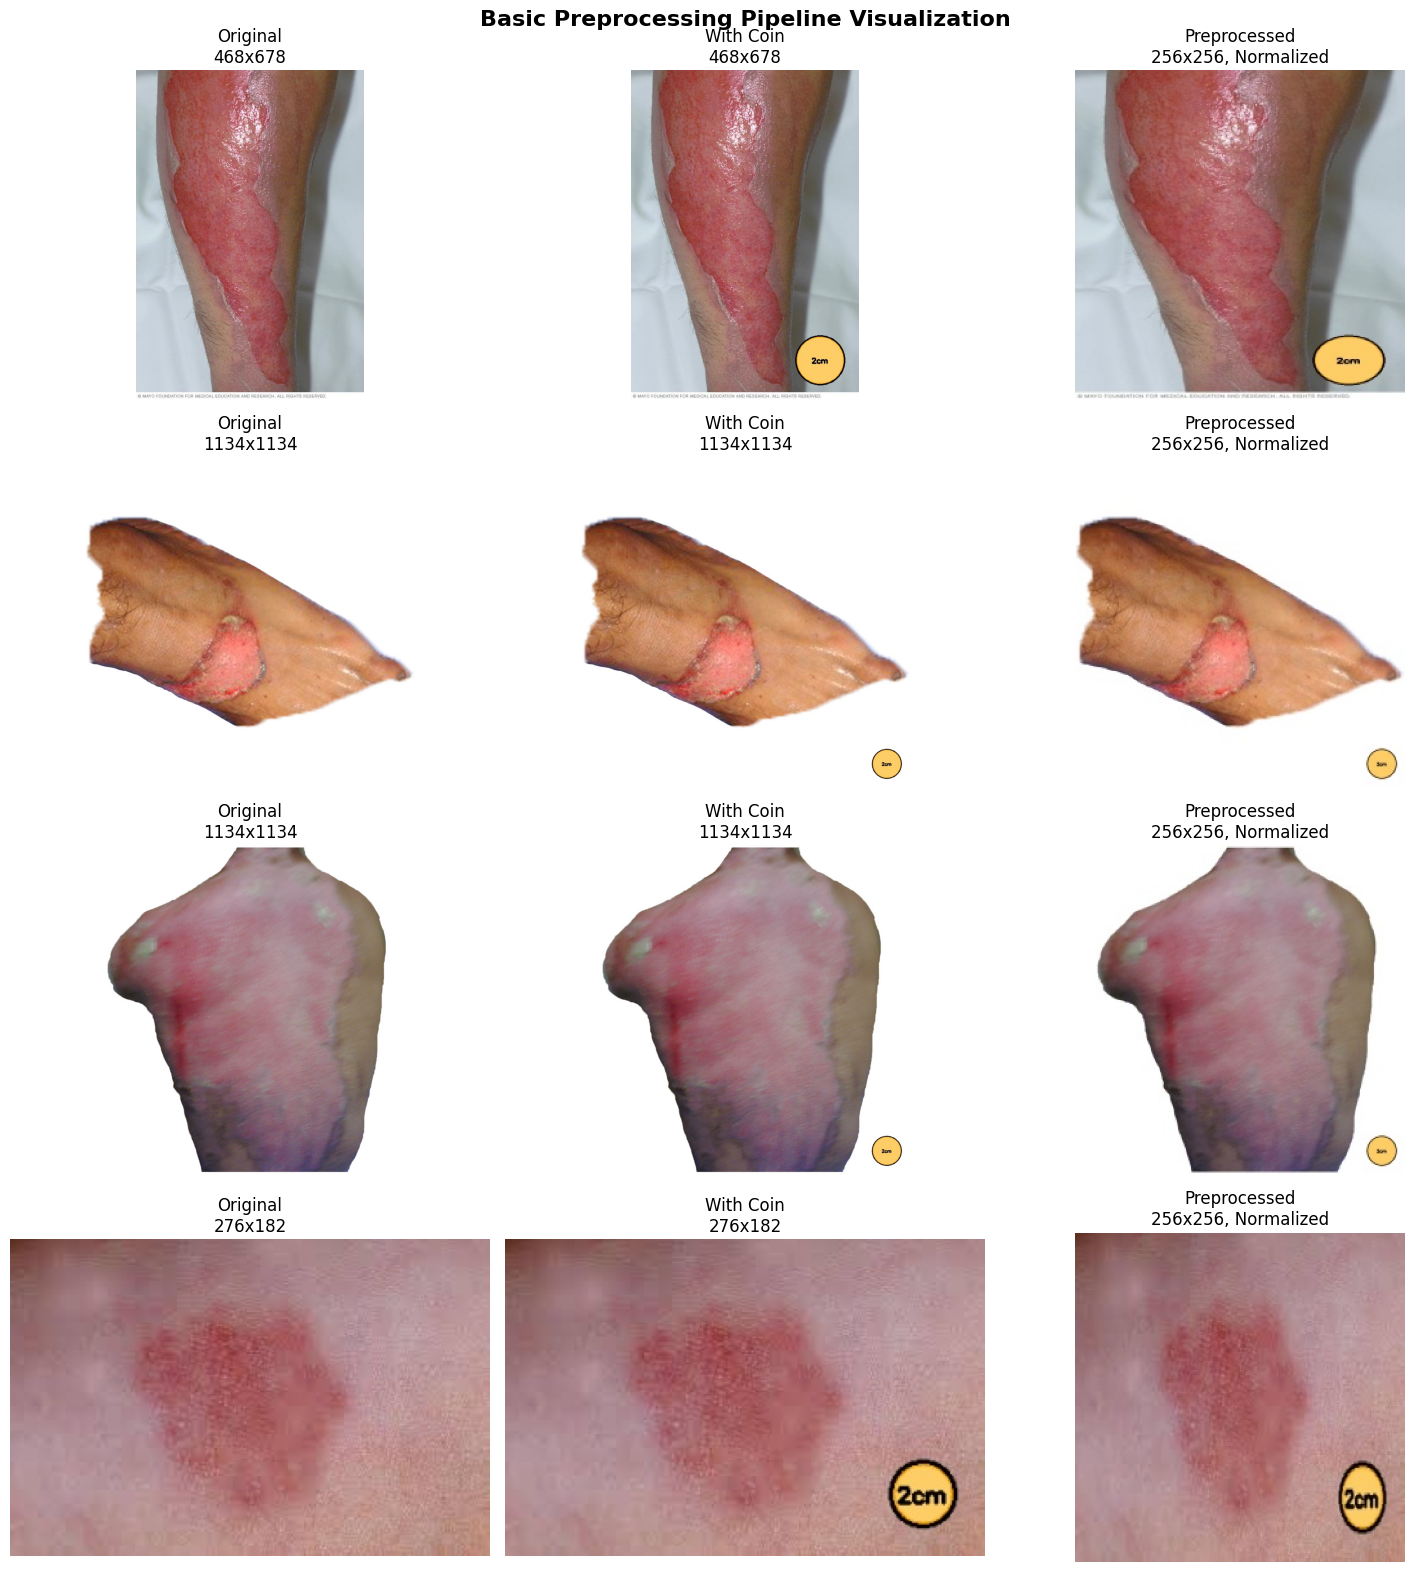

✓ Visualization saved to: /content/processed_dataset/metadata/basic_preprocessing_visualization.png


In [ ]:
# ===================================================================
# CELL 11: Visualisasi Hasil Preprocessing Dasar
# ===================================================================
def visualize_basic_preprocessing(original_folder, processed_folder, num_samples=4):
    """
    Visualisasi perbandingan sebelum dan sesudah preprocessing dasar
    """
    image_files = list(Path(processed_folder).glob('*.jpg'))[:num_samples]

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))

    for idx, processed_img_path in enumerate(image_files):
        # Cari gambar original dan dengan koin
        original_img_path = os.path.join(ORGANIZED_DIR, processed_img_path.name)
        coin_img_path = os.path.join(COIN_DIR, processed_img_path.name)

        # Baca semua gambar
        original_img = cv2.imread(original_img_path)
        coin_img = cv2.imread(str(coin_img_path))
        processed_img = cv2.imread(str(processed_img_path))

        if original_img is not None and coin_img is not None and processed_img is not None:
            # Convert BGR to RGB untuk display
            original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            coin_img_rgb = cv2.cvtColor(coin_img, cv2.COLOR_BGR2RGB)
            processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

            # Plot original
            axes[idx, 0].imshow(original_img_rgb)
            axes[idx, 0].set_title(f'Original\n{original_img.shape[1]}x{original_img.shape[0]}')
            axes[idx, 0].axis('off')

            # Plot with coin
            axes[idx, 1].imshow(coin_img_rgb)
            axes[idx, 1].set_title(f'With Coin\n{coin_img.shape[1]}x{coin_img.shape[0]}')
            axes[idx, 1].axis('off')

            # Plot processed
            axes[idx, 2].imshow(processed_img_rgb)
            axes[idx, 2].set_title(f'Preprocessed\n256x256, Normalized')
            axes[idx, 2].axis('off')

    plt.suptitle('Basic Preprocessing Pipeline Visualization', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{METADATA_DIR}/basic_preprocessing_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Visualization saved to: {METADATA_DIR}/basic_preprocessing_visualization.png")

# Visualisasi
print("\n" + "=" * 70)
print("VISUALIZING PREPROCESSING RESULTS")
print("=" * 70)

visualize_basic_preprocessing(ORGANIZED_DIR, PREPROCESSED_DIR, num_samples=4)


In [ ]:
# ===================================================================
# CELL 12: Fungsi Noise Reduction (OPSIONAL - jika masih diperlukan)
# ===================================================================
def apply_noise_reduction(image, method='median', kernel_size=3):
    """
    Menghilangkan noise dari gambar (opsional, bisa digunakan jika diperlukan)
    """
    if kernel_size % 2 == 0:
        kernel_size += 1

    if method == 'gaussian':
        denoised = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    elif method == 'median':
        denoised = cv2.medianBlur(image, kernel_size)
    elif method == 'bilateral':
        denoised = cv2.bilateralFilter(image, kernel_size, 75, 75)
    else:
        denoised = image

    return denoised

In [ ]:
# ===================================================================
# CELL 13: Fungsi Konversi ke HSV (OPSIONAL - untuk analisis warna)
# ===================================================================
def convert_to_hsv(image):
    """
    Konversi gambar RGB ke HSV color space (opsional, untuk analisis lebih lanjut)
    """
    # Konversi ke HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Split channels
    h, s, v = cv2.split(hsv)

    return hsv, h, s, v

In [ ]:
# ===================================================================
# CELL 14: Data Augmentation Functions (SAMA)
# ===================================================================
def augment_image(image, augmentation_type):
    """
    Augmentasi gambar dengan berbagai teknik
    """
    if augmentation_type == 'horizontal_flip':
        return cv2.flip(image, 1)

    elif augmentation_type == 'vertical_flip':
        return cv2.flip(image, 0)

    elif augmentation_type == 'rotation_90':
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

    elif augmentation_type == 'rotation_180':
        return cv2.rotate(image, cv2.ROTATE_180)

    elif augmentation_type == 'rotation_270':
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

    elif augmentation_type == 'brightness_increase':
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 2] = np.clip(hsv[:, :, 2] * 1.2, 0, 255)
        return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    elif augmentation_type == 'brightness_decrease':
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 2] = np.clip(hsv[:, :, 2] * 0.8, 0, 255)
        return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    else:
        return image


In [ ]:
# ===================================================================
# CELL 15: Batch Data Augmentation
# ===================================================================
def batch_augmentation(input_folder, output_folder, augmentation_list=None):
    """
    Augmentasi batch untuk semua gambar
    """
    if augmentation_list is None:
        augmentation_list = [
            'horizontal_flip',
            'vertical_flip',
            'rotation_90',
            'rotation_180',
            'brightness_increase',
            'brightness_decrease'
        ]

    image_files = list(Path(input_folder).glob('*.jpg'))

    augmented_count = 0
    metadata_list = []

    print(f"🔄 Augmenting {len(image_files)} images with {len(augmentation_list)} techniques...")

    for img_path in tqdm(image_files, desc="Augmentation"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        base_name = img_path.stem

        for aug_type in augmentation_list:
            # Apply augmentation
            aug_img = augment_image(img, aug_type)

            # Save augmented image
            output_filename = f"{base_name}_{aug_type}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_path, aug_img)

            metadata_list.append({
                'original_file': img_path.name,
                'augmented_file': output_filename,
                'augmentation_type': aug_type
            })

            augmented_count += 1

    # Simpan metadata
    df = pd.DataFrame(metadata_list)
    df.to_csv(f'{METADATA_DIR}/augmentation_metadata.csv', index=False)

    print(f"\n✅ Augmentation complete! {augmented_count} augmented images created.")
    print(f"📊 Original: {len(image_files)} → Total: {len(image_files) + augmented_count}")

    return metadata_list

# Jalankan augmentation
print("\n" + "=" * 70)
print("DATA AUGMENTATION")
print("=" * 70)

augmentation_metadata = batch_augmentation(
    input_folder=PREPROCESSED_DIR,
    output_folder=AUGMENTED_DIR,
    augmentation_list=[
        'horizontal_flip',
        'vertical_flip',
        'rotation_90',
        'brightness_increase',
        'brightness_decrease'
    ]
)



DATA AUGMENTATION
🔄 Augmenting 185 images with 5 techniques...


Augmentation: 100%|██████████| 185/185 [00:00<00:00, 242.53it/s]


✅ Augmentation complete! 925 augmented images created.
📊 Original: 185 → Total: 1110



VISUALIZING AUGMENTATION RESULTS


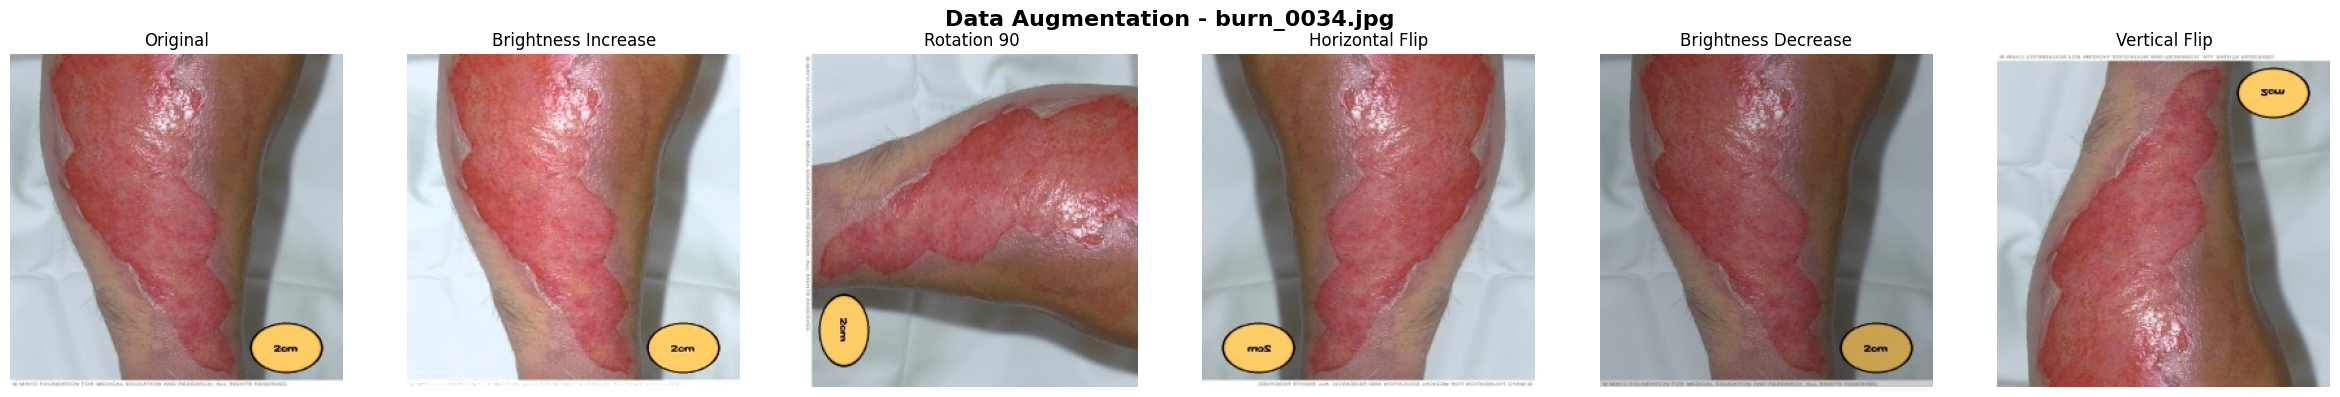

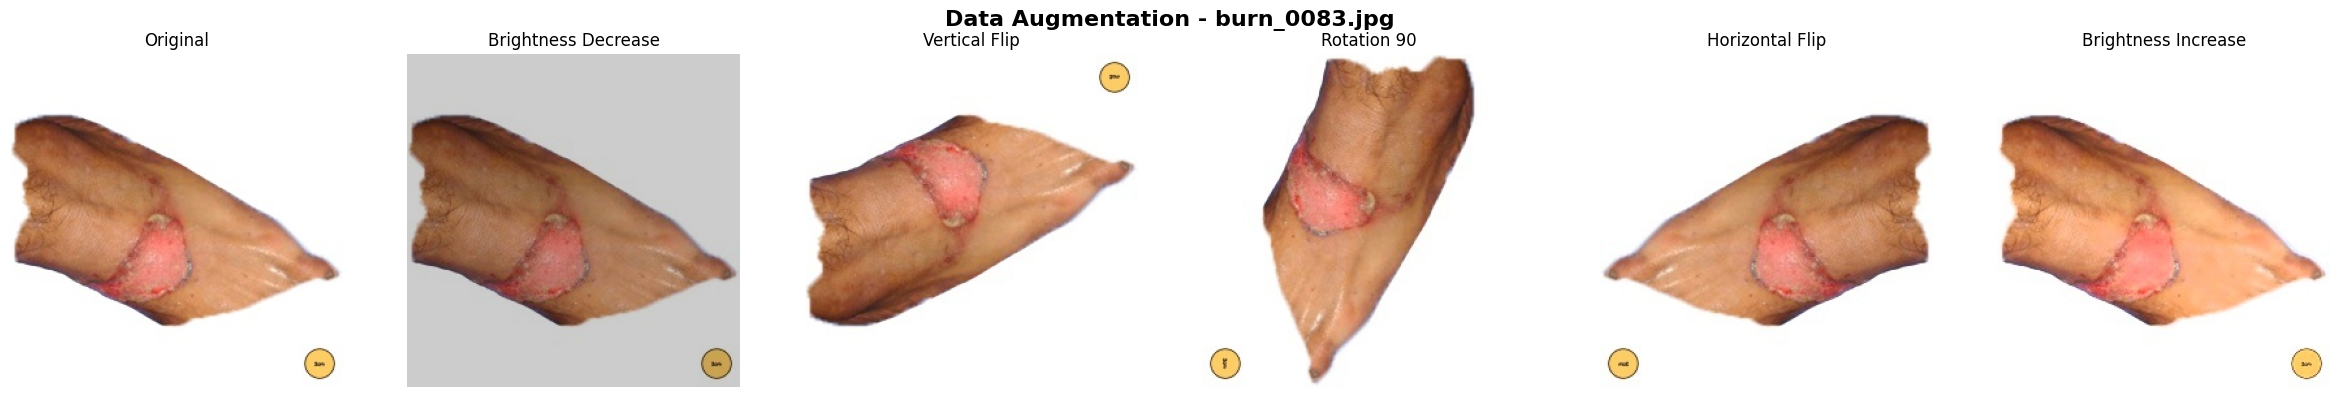

In [ ]:
# ===================================================================
# CELL 16: Visualisasi Data Augmentation
# ===================================================================
def visualize_augmentation(original_folder, augmented_folder, num_samples=2):
    """
    Visualisasi hasil augmentasi
    """
    # Ambil beberapa gambar original
    original_files = list(Path(original_folder).glob('*.jpg'))[:num_samples]

    for orig_file in original_files:
        base_name = orig_file.stem

        # Cari semua augmented versions
        aug_files = list(Path(augmented_folder).glob(f'{base_name}_*.jpg'))

        # Plot
        n_augs = len(aug_files)
        fig, axes = plt.subplots(1, n_augs + 1, figsize=(4 * (n_augs + 1), 4))

        # Original
        orig_img = cv2.imread(str(orig_file))
        axes[0].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original')
        axes[0].axis('off')

        # Augmented
        for idx, aug_file in enumerate(aug_files):
            aug_img = cv2.imread(str(aug_file))
            aug_type = aug_file.stem.replace(f'{base_name}_', '')

            axes[idx + 1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
            axes[idx + 1].set_title(aug_type.replace('_', ' ').title())
            axes[idx + 1].axis('off')

        plt.suptitle(f'Data Augmentation - {orig_file.name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{METADATA_DIR}/augmentation_viz_{base_name}.png', dpi=150, bbox_inches='tight')
        plt.show()

# Visualisasi
print("\n" + "=" * 70)
print("VISUALIZING AUGMENTATION RESULTS")
print("=" * 70)

visualize_augmentation(PREPROCESSED_DIR, AUGMENTED_DIR, num_samples=2)


GENERATING DATASET STATISTICS


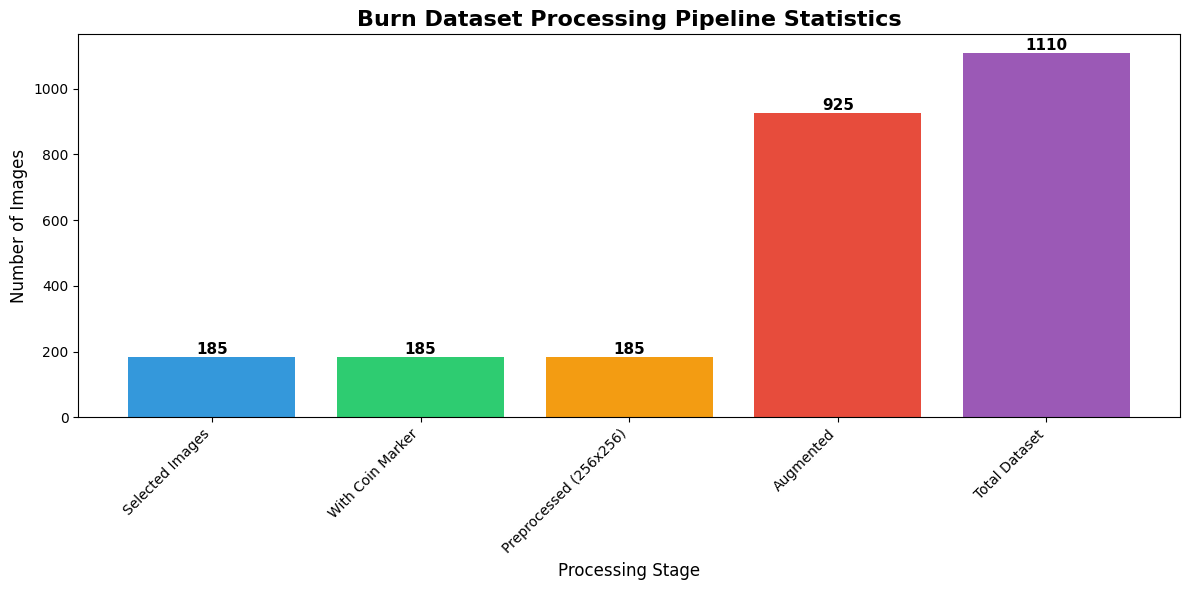

DATASET STATISTICS SUMMARY
                 Stage  Count                           Description
       Selected Images    185          200 images manually selected
      With Coin Marker    185              Added 2cm reference coin
Preprocessed (256x256)    185        RGB, 256x256, normalized [0,1]
             Augmented    925 Horizontal flip, rotation, brightness
         Total Dataset   1110              Ready for model training


In [ ]:
# ===================================================================
# CELL 17: Dataset Statistics dan Summary
# ===================================================================
def generate_dataset_statistics():
    """
    Generate statistik lengkap dataset
    """
    stats = {
        'original_selected': len(list(Path(ORGANIZED_DIR).glob('*.jpg'))),
        'with_coins': len(list(Path(COIN_DIR).glob('*.jpg'))),
        'preprocessed': len(list(Path(PREPROCESSED_DIR).glob('*.jpg'))),
        'augmented': len(list(Path(AUGMENTED_DIR).glob('*.jpg'))),
    }

    stats['total_processed'] = stats['preprocessed'] + stats['augmented']

    # Create summary DataFrame
    summary_data = {
        'Stage': ['Selected Images', 'With Coin Marker', 'Preprocessed (256x256)', 'Augmented', 'Total Dataset'],
        'Count': [
            stats['original_selected'],
            stats['with_coins'],
            stats['preprocessed'],
            stats['augmented'],
            stats['total_processed']
        ],
        'Description': [
            '200 images manually selected',
            'Added 2cm reference coin',
            'RGB, 256x256, normalized [0,1]',
            'Horizontal flip, rotation, brightness',
            'Ready for model training'
        ]
    }

    df_summary = pd.DataFrame(summary_data)

    # Visualize
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df_summary['Stage'], df_summary['Count'],
                   color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'])
    plt.title('Burn Dataset Processing Pipeline Statistics', fontsize=16, fontweight='bold')
    plt.xlabel('Processing Stage', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{METADATA_DIR}/dataset_statistics.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print detailed statistics
    print("=" * 70)
    print("DATASET STATISTICS SUMMARY")
    print("=" * 70)
    print(df_summary.to_string(index=False))
    print("=" * 70)

    # Save to CSV
    df_summary.to_csv(f'{METADATA_DIR}/dataset_statistics.csv', index=False)

    return stats, df_summary

# Generate statistics
print("\n" + "=" * 70)
print("GENERATING DATASET STATISTICS")
print("=" * 70)

dataset_stats, summary_df = generate_dataset_statistics()

In [ ]:
# ===================================================================
# CELL 19: Export ke Google Drive
# ===================================================================
def export_to_drive(source_dir, drive_destination):
    """
    Export processed dataset ke Google Drive
    """
    print(f"\n📤 Exporting processed dataset to Google Drive...")
    print(f"   Source: {source_dir}")
    print(f"   Destination: {drive_destination}")

    # Buat folder di Drive jika belum ada
    os.makedirs(drive_destination, exist_ok=True)

    # Copy seluruh folder
    !cp -r {source_dir}/* {drive_destination}/

    print(f"✅ Dataset exported successfully!")
    print(f"📁 Location: {drive_destination}")

# Export ke Google Drive
DRIVE_OUTPUT = '/content/drive/MyDrive/BurnDetection_ProcessedDataset/FINAL_PROCESSED_2'
export_to_drive(OUTPUT_DIR, DRIVE_OUTPUT)


📤 Exporting processed dataset to Google Drive...
   Source: /content/processed_dataset
   Destination: /content/drive/MyDrive/BurnDetection_ProcessedDataset/FINAL_PROCESSED_2
✅ Dataset exported successfully!
📁 Location: /content/drive/MyDrive/BurnDetection_ProcessedDataset/FINAL_PROCESSED_2
